In [15]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

## Specify dataset files to run over ##
path = "/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL{year}_ml_inputs/{dataset}.parquet"

datasets = [
    'ttH_HToInvisible_M125',
    'TTToSemiLeptonic',
]
years = ['2018']

files = [
    path.format(year=year, dataset=dataset)
    for dataset in datasets
    for year in years
]

## Data preprocessing ##
df = load_from_parquet(files)
df = remove_negative_events(df)
df["target"] = create_target_labels(df["dataset"])
apply_reweighting_per_class(df)
reweighting = torch.Tensor(df['weight_training'].values)
df["target"] = create_target_labels(df["dataset"])

X, y, pad_mask = awkward_to_inputs_parallel(df, n_processes=8, target_length=10)

event_level = get_event_level(df)
#split_masks = kfold_split(df, k=2)      # returns a list with a mask for each fold, so if only training one select it in line below
#split = split_masks[0]

## Create training datasets ##
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level, 
    test_size=0.2,  
    random_state=42,
)

train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    #num_workers = 20,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

2024-11-18 10:30:37,355 - INFO - Loading data from 2 parquet files...
2024-11-18 10:30:37,355 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet
2024-11-18 10:30:39,943 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet contains 266650 events
2024-11-18 10:30:40,011 - INFO - Filtered df contains 144551 events from regions [0]
2024-11-18 10:30:40,107 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet
2024-11-18 10:30:59,859 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToSemiLeptonic.parquet contains 2468208 events
2024-11-18 10:31:00,114 - INFO - Filtered df contains 437503 events from regions [0]
2024-11-18 10:31:01,612 - INFO - DataFrame loaded successfully with 582054 entries.
2024-11-18 10:31:01,719 - INFO - Negative events = 7515 [1.29%]...
2024-11-18 10:31:02,002 - INFO - Negativ

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


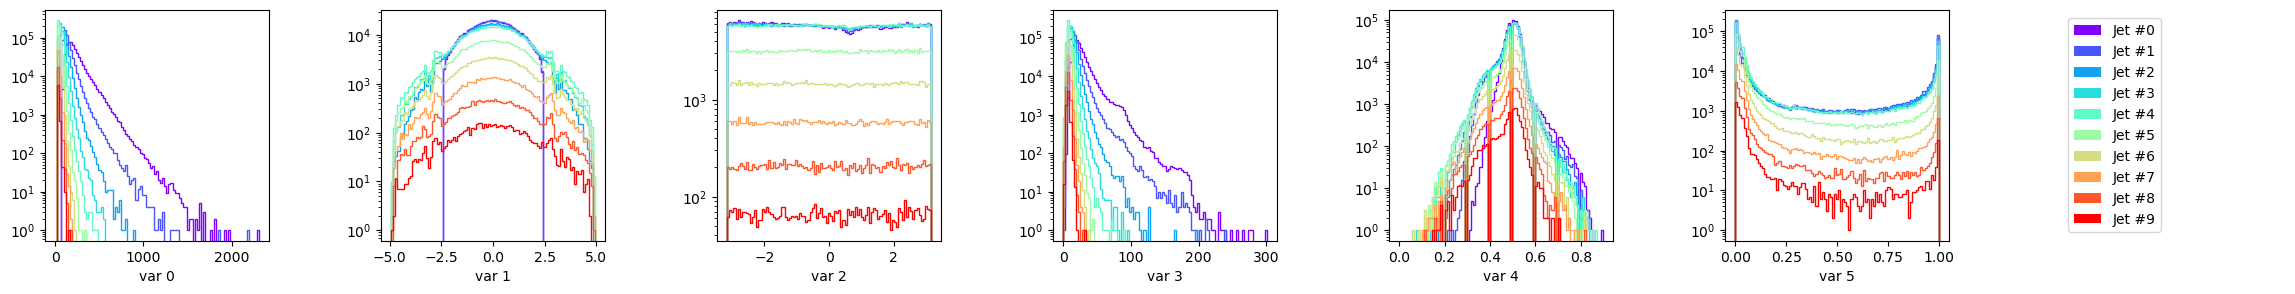

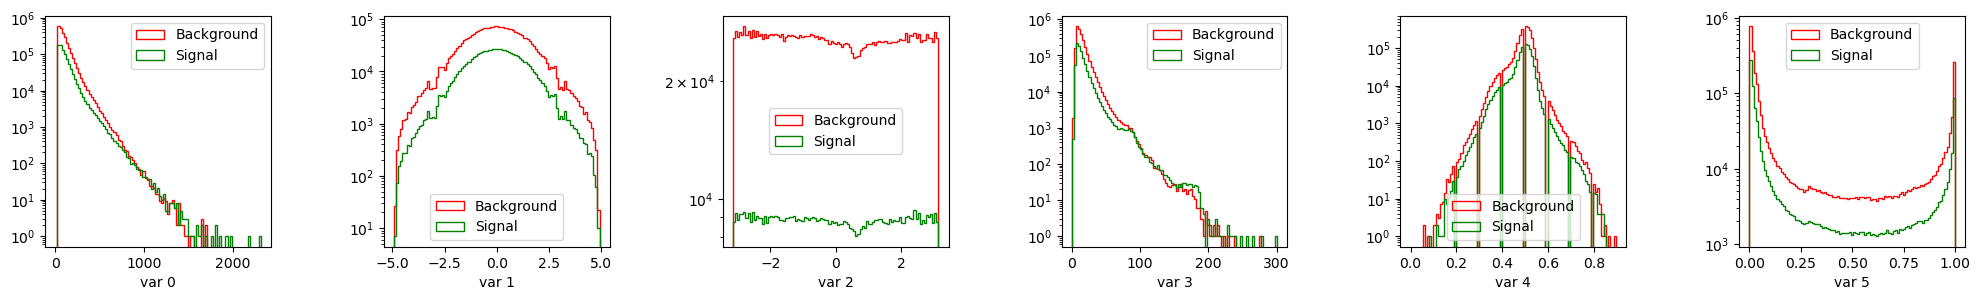

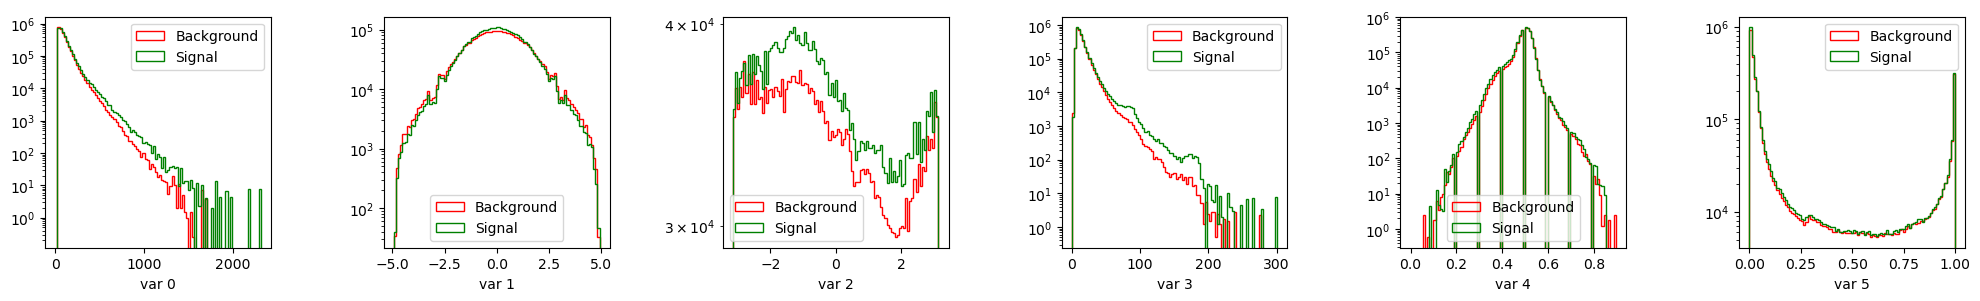

In [3]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [6]:
# Define model #
loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = 1,                  # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor)
    encoder_layers = 4,              # Number of encoder layers (self attention on jets)
    class_layers = 2,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = 3,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.25,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-3): 4 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [7]:
##### Parameters #####
epochs = 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.5, 
   patience = 10, 
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
logger = CometLogger(
    api_key = os.environ.get("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = "Setup",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = 1,
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        plots_callback,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Training   : Batch size = 1024 => 449 steps per epoch
Validation : Batch size = 10000 => 12 steps per epoch


COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/analysisobjecttransformer/95e3177cda3242cc9b4ca59c2eb4e15e

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type                | Params | Mode 
---------------------------------------------------------------
0 | embedding      | Embedding           | 460    | train
1 | encoder_blocks | ModuleList          | 202 K  | train
2 | class_blocks   | ModuleList          | 101 K  | train
3 | dnn            | Sequential          | 82.7 K | train
4 | loss_function  | BCEDecorrelatedLoss | 0      | train
  | other params   | n/a                 | 64     | n/a  
---------------------------------------------------------------
386 K     Trainable params
0         Non-trainable params
386 K     Total params
1.548     Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/software/lw23382/miniconda/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/software/lw23382/miniconda/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved. New best score: 1.281


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.031 >= min_delta = 0.0. New best score: 1.251


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.021 >= min_delta = 0.0. New best score: 1.229


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.032 >= min_delta = 0.0. New best score: 1.198


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.004 >= min_delta = 0.0. New best score: 1.194


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.016 >= min_delta = 0.0. New best score: 1.178


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.021 >= min_delta = 0.0. New best score: 1.157


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.011 >= min_delta = 0.0. New best score: 1.147


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 1.144


Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.010 >= min_delta = 0.0. New best score: 1.134


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val/loss_tot improved by 0.000 >= min_delta = 0.0. New best score: 1.134

Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : https://www.comet.com/florianbury/analysisobjecttransformer/95e3177cda3242cc9b4ca59c2eb4e15e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train/loss_bce [13]   : (1.0682146549224854, 1.3407150506973267)
COMET INFO:     train/loss_disco [13] : (0.009443667717278004, 0.14973224699497223)
COMET INFO:     train/loss_tot [13]   : (1.0790866613388062, 1.3502357006072998)
COMET INFO:     val/loss_bce [13]     : (1.1207290887832642, 1.2762088775634766)
COMET IN

NameError: name 'exit' is not defined

In [8]:
## Testing model performance on validation set ##
preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/analysisobjecttransformer/95e3177cda3242cc9b4ca59c2eb4e15e

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/software/lw23382/miniconda/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                             | 0/? [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : https://www.comet.com/florianbury/analysisobjecttransformer/95e3177cda3242cc9b4ca59c2eb4e15e
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : Setup
COMET INFO:   Uploads:
COMET INFO:     model graph : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET INFO: Please wait for metadata to finish uploading (timeout is 3600 seconds)
COMET INFO: Uploading 1 metrics, params and output messages


In [11]:
labels.shape,preds.shape

(torch.Size([114908, 1]), torch.Size([114908, 1]))

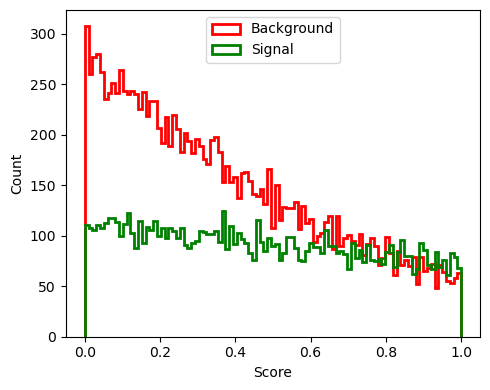

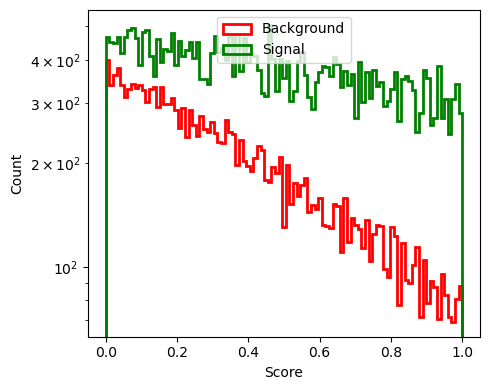

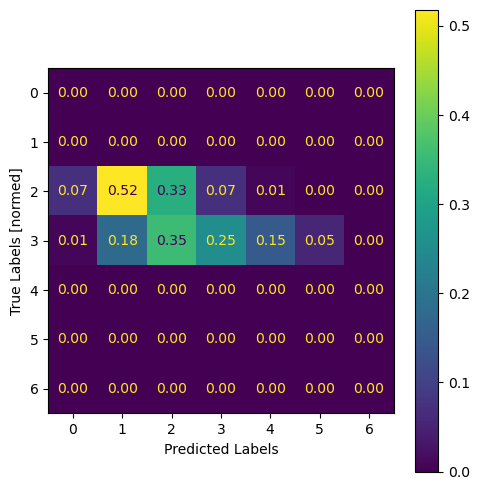

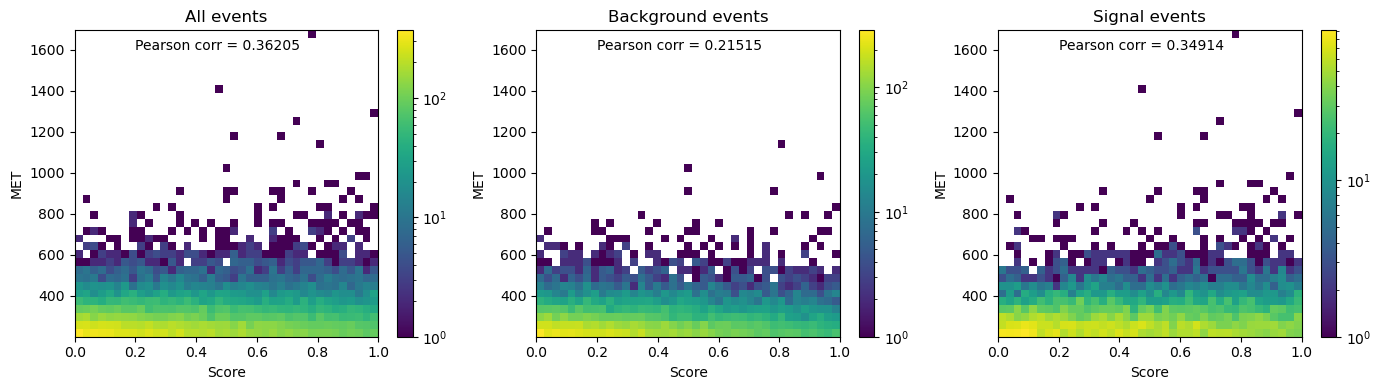

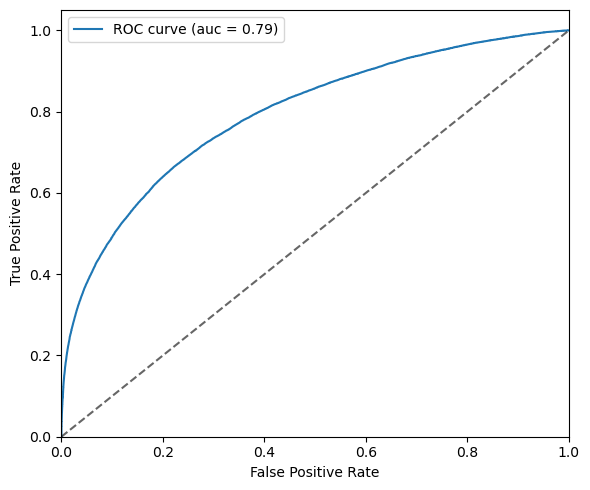

In [9]:
fig = plot_score(labels,preds,outdir=outdir,bins=100,log=False)
fig = plot_score(labels,preds,weights=weights,outdir=outdir,bins=100,log=True)
fig = plot_confusion_matrix(labels, preds, outdir=outdir,show=True)
fig = plot_correlation(labels,preds,event,outdir=outdir,log=True,bins=40)
fig = plot_roc(labels, preds, outdir=outdir,show=True)

hell
torch.Size([114908, 1]) torch.Size([114908, 1])
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.0721602  0.51789891 0.3274112  0.07177998 0.00982798 0.00092173
  0.        ]
 [0.00874978 0.17961942 0.35415259 0.2540281  0.14700338 0.0549173
  0.00152943]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]]


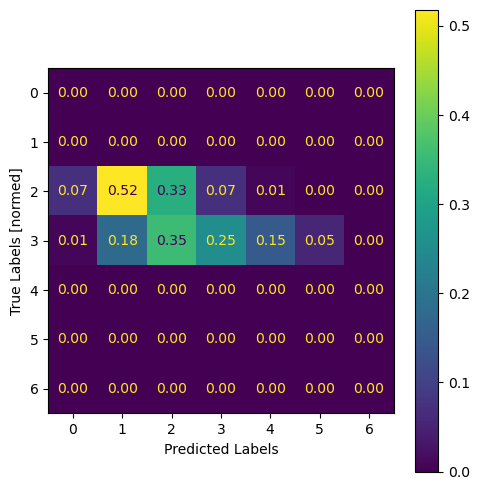

In [21]:
%autoreload 2
fig = plot_confusion_matrix(labels, preds, outdir=outdir,show=True)
